# Natural Language Processing

To work in this Colab notebook, first save a copy of it via "File" -> "Save a copy in Drive" in the top-left menu bar.


### 1. Install all missing packages that we need an download our custom Twitter data

The data files will be available locally in your Colab runtime. You can find them through the files menu on the left.

In [ ]:
!pip install gdown torchmetrics transformers

!gdown https://drive.google.com/uc?id=107hiJw15Vr0NnjBCDcY7E4z7KSYrMuZq
!gdown https://drive.google.com/uc?id=11Vydscp7E5JRw0t-N4nsWyqjbXi9ovCu
!gdown https://drive.google.com/uc?id=1r9a0J-hiiFBILjFiNLnjzd35qyypRM3H

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 68.8 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=107hiJw15Vr0NnjBCDcY7E4z7KSYrMuZq
To: /content/mini_twitter_binary_training.csv
100% 2.53M/2.53M [00:00<00:00, 63.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=11Vydscp7E5JRw0t-N4nsWyqjbXi9ovCu
To: /content/mini_twitter_binary_validation.csv
100% 314k/314k [00:00<00:00, 129MB/s]
Downloading...
From: https://drive.google.com/uc?id=1r9a0J-hiiFBILjFiNLnjzd35qyypRM3H
To: /content/mini_twitter_binary_test.csv
100% 315k/315k [00:00<00:00, 106MB/s]


### 2. Import classes and functions we will be using

In [ ]:
from collections import Counter, OrderedDict
import itertools
import builtins
import math
import os
import random
from typing import Any, Callable, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import vocab, Vocab
from torchtext.data.functional import simple_space_split
from torchtext.transforms import ToTensor
from torchmetrics.functional.classification import multiclass_confusion_matrix
from transformers import (
    AdamW,
    PreTrainedTokenizer,
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification
)

### 3. Check which PyTorch version we are running and confirm that we are in a GPU runtime.
If this output shows that you are not in a GPU runtime, go to "Runtime" in the top-left menu bar -> "Change runtime type" -> set "Hardware Accelerator: GPU".

In [ ]:
print(f"Running PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

!nvidia-smi

device = "cuda" if torch.cuda.is_available() else "cpu"

Running PyTorch version: 2.0.0+cu118
CUDA available: True
Tue Apr  4 17:18:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                              

### 4. Make things (more) reproducible by setting random seeds

See here for details: https://pytorch.org/docs/stable/notes/randomness.html

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### 5. Load our data from the downloaded CSV files

In [ ]:
def get_data(csv_filepath: str):
  data = pd.read_csv(csv_filepath, sep="\t")
  texts, labels = list(data["clean_text"]), list(data["category"])
  return texts, labels

train_texts, train_labels = get_data("mini_twitter_binary_training.csv")
validation_texts, validation_labels = get_data("mini_twitter_binary_validation.csv")
test_texts, test_labels = get_data("mini_twitter_binary_test.csv")

### 6. Tokenize the training data and plot 30 most common tokens

TODO: You should implement this yourself. Use simple white space tokenization

Tokenize the training set with a simple whitespace tokenizer and plot a histogram of the 30 most common tokens.


In [ ]:
# TODO
import nltk
from nltk.tokenize import WhitespaceTokenizer
token_list = []
for text in train_texts: 
    token_white = WhitespaceTokenizer().tokenize(text)
    for s in token_white:
        token_list.append(s)

In [ ]:
df = pd.DataFrame(token_list)
df.value_counts()
newdf = pd.DataFrame(df.value_counts())

In [ ]:
newdf[0:31]

,0
0,
modi,16569
the,13003
and,8457
for,6367
you,4913
not,3599
that,3582
this,3541
india,3510


array([[<Axes: title={'center': '0'}>]], dtype=object)

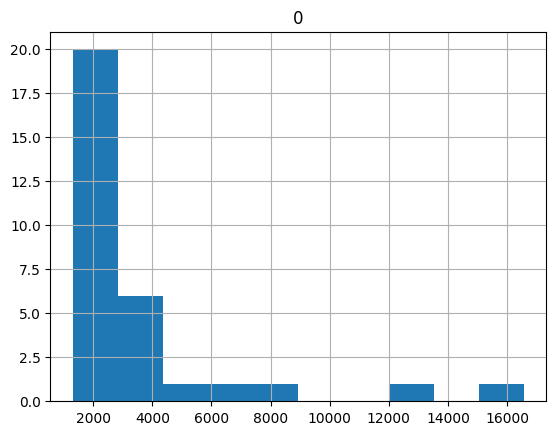

In [ ]:
newdf.iloc[0:31].hist()

### 7. Create vocabulary with `<UNK>` and `<PAD>` tokens

In [ ]:
tokens = list(itertools.chain(*simple_space_split(train_texts)))
counter = Counter(tokens)
# Sort tokens by frequency in reverse order
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
unk_token = "<UNK>"
pad_token = "<PAD>"
# Create vocabulary with UNK and PAD token added. Vocabulary retains reverse sorted order
vocabulary = vocab(OrderedDict(sorted_by_freq_tuples), specials=[unk_token, pad_token], special_first=False)
# Out-of-vocabulary (UNK) token is the default
vocabulary.set_default_index(vocabulary[unk_token])

### 8. Define our custom IDS Text PyTorch datasets

Our model inherits, i.e. is a specific kind of, `Dataset` in torch.\
This means it has all features defined in `Dataset`, unless they are explicitly overridden here, \
plus any additional functionality that may be defined below. You can read more about `Dataset` here: https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset.

We define two versions: `IDSTextDataset`, for use with CBoW, and `IDSTextTokenizedDataset`, for use with DistilBERT. \
We also define custom collate functions for the respective dataloaders. See here for information on batch collation https://pytorch.org/docs/stable/data.html#working-with-collate-fn.

In [ ]:
class IDSTextDataset(Dataset):
  """
  Custom IDS Torch Dataset to be used with CBoW
  """
  
  classes = ["negative", "positive"]
  
  def __init__(
    self,
    texts: List[str],
    targets: List[int],
  ) -> None:
    super().__init__()
    
    self.texts = texts
    self.targets = targets
    
  def __getitem__(self, idx: int) -> Tuple[Any, Any]:
    """
    Args:
        idx (int): Index

    Returns:
        tuple: (text, target) where target is index of the target class.
    """
    return self.texts[idx], int(self.targets[idx])
    
  def __len__(self):
    return len(self.texts)

def cbow_collate_fn(examples):
  """
  Batch collate function to be used with CBoW
  """

  texts = [example[0] for example in examples]
  # Whitespace-tokenize the texts and pad them to the same length
  texts = pad_sequence(
    [ToTensor()(vocabulary(tokens)) for tokens in simple_space_split(texts)],
    padding_value=vocabulary[pad_token]
  ).transpose(1, 0)
  labels = ToTensor()([example[1] for example in examples])

  return texts, labels


class IDSTextTokenizedDataset(Dataset):
  """
  Custom IDS Torch Dataset to be used with DistilBERT
  """

  classes = ["negative", "positive"]

  def __init__(
    self,
    texts: List[str],
    labels: List[int],
    tokenizer: PreTrainedTokenizer
  ):
    self.encodings = tokenizer(texts, truncation=True, padding=True)
    self.labels = labels

  def __getitem__(self, idx: int):
      encoding = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      encoding["labels"] = torch.tensor(self.labels[idx])
      return encoding

  def __len__(self):
      return len(self.labels)


def distilbert_collate_fn(examples):
  """
  Batch collate function to be used with DistilBERT
  """
  input_ids = torch.stack([example["input_ids"] for example in examples])
  attention_mask = torch.stack([example["attention_mask"] for example in examples])
  labels = torch.stack([example["labels"] for example in examples])
  return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


### 6. Define our CBoW Model


In [ ]:
class CBoWClassifier(nn.Module):
    
  def __init__(self, vocab, num_labels, emb_dim, n_hidden=100, dropout=0.5):
    super().__init__()     

    self.vocab = vocab        
    self.embedding = nn.Embedding(len(vocab), emb_dim)
    self.hidden_layer = nn.Linear(emb_dim, n_hidden)
    self.out_layer = nn.Linear(n_hidden, num_labels)
    self.dropout = nn.Dropout(dropout)
    self.loss_fn = nn.CrossEntropyLoss()

  def forward(self, texts):
    embedded = self.embedding(texts)
    cbow = embedded.mean(dim=-2)
    cbow_drop = self.dropout(cbow)
    hidden = F.relu(self.hidden_layer(cbow_drop))
    outputs = self.out_layer(hidden)
    return outputs

  def get_most_common_word_embedding(self, topk: int = 2000):
    """
    Method to return the word embeddings of the topk most common words in the
    vocabulary.

    Returns:
      Dictionary with words/tokens (`str`) as keys and word embeddings (`np.array`) as values
    """

    words = self.vocab.lookup_tokens(list(range(topk)))
    word_embeddings = self.embedding(torch.arange(topk).to(device))
    return {
        word: word_embedding.detach().cpu().numpy() 
        for word, word_embedding in zip(words, word_embeddings)
    }

### 7. Load our custom Twitter data for CBoW

Here, we load our data to be used with CBoW using the `IDSTextDataset` class defined above.

In [ ]:
train_dataset = IDSTextDataset(train_texts, train_labels)
validation_dataset = IDSTextDataset(validation_texts, validation_labels)
test_dataset = IDSTextDataset(test_texts, test_labels)

# Check the sizes of our datasets
print(f"Training dataset length = {len(train_dataset)}")
print(f"Validation dataset length = {len(validation_dataset)}")
print(f"Test dataset length = {len(test_dataset)}")

Training dataset length = 17241
Validation dataset length = 2155
Test dataset length = 2155


### 8. Implement our evaluation function and training loop

Below, we provide some rudimentary functionality for training and evaluation,\
as well as metric storing and logging, for our experiments.

The functions are designed to work both with CBoW and DistilBERT when using our `CBoWClassifier` model and the collate functions \
defined above and the `DistilBertForSequenceClassification` from Hugging Face (https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.DistilBertForSequenceClassification).

In [ ]:
def log_metrics(metrics: dict, step: Optional[int] = None):
    """
    Log metrics stored in a dictionary
    """

    # During training, it can be useful to also log the current step
    if step is not None:
        print(f"\nMetrics step {step}:")

    for k, v in metrics.items():
        # We ignore the confusion matrix when logging metrics
        if not k.endswith("conf_matrix"):
            print(f"  {k}: {v}")

def evaluate(model, eval_dataloader, prefix="eval"):
    """
    Evaluation function that computes the loss, accuracy, and confusion matrix for the dataset
    passed via the `eval_dataloader` argument
    """
    
    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Move model to GPU if available
    model.to(device)

    # Set model to evaluation mode (e.g. to disable dropout)
    model.eval()

    eval_loss = 0
    y_pred = None
    y_true = None
    
    for batch_idx, batch in enumerate(tqdm(eval_dataloader, desc=f"Evaluating")):
        # Loop over batches in dataloader
        
        # This is for using DistilBERT
        if isinstance(batch, dict):
          for k, v in batch.items():
            batch[k] = v.to(device)

          with torch.no_grad():
            outputs = model(**batch)
          
          loss = outputs["loss"]

          # Get class predictions and labels
          preds = torch.argmax(outputs["logits"], dim=-1)
          labels = batch["labels"]

        # This for using CBoW
        else:
          inputs, labels = batch
          inputs = inputs.to(device)
          labels = labels.to(device)

          with torch.no_grad():
            outputs = model(inputs)
          
          loss = criterion(outputs, labels)

          # Get class predictions
          preds = torch.argmax(outputs, dim=-1)

        eval_loss += loss.detach().cpu().item()
        
        # Accumulate predictions and true classes over batches
        y_pred = torch.cat([y_pred, preds]) if y_pred is not None else preds
        y_true = torch.cat([y_true, labels]) if y_true is not None else labels

    
    # Move predictions and true classes back to CPU
    y_pred = y_pred.detach().cpu()
    y_true = y_true.detach().cpu()
  
    # Compute metrics
    eval_loss /= len(eval_dataloader)
    eval_acc = (y_pred == y_true).sum() / len(y_true)
    eval_conf_matrix = multiclass_confusion_matrix(
        y_pred, y_true, num_classes=2
    )
    
    # Store metrics in a dictionary
    metrics = {
        f"{prefix}_loss": eval_loss,
        f"{prefix}_accuracy": eval_acc.item(),
        f"{prefix}_conf_matrix": eval_conf_matrix.numpy()
    }

    return metrics


def save_best_model(model: nn.Module):
  """
  Simple function that saves the weights of the specified model to disk.
  We use this to keep track of the best model (based on validation loss).
  """
  output_path = "best_model.pt"
  torch.save(model.state_dict(), output_path)
  print(f"Saved new best model to {output_path}\n")


def load_best_model(model: nn.Module, model_path: str = "best_model.pt"):
  """
  Simple function that loads model weights stored at `model_path` into the 
  passed model of type `nn.Module`. We use this to load our best model checkpoint.
  """
  model.load_state_dict(torch.load(model_path))
  model.eval()
  print(f"Loaded best {model.__class__.__name__} model from {model_path}\n")
  return model


def train(
  model: nn.Module,
  train_dataloader: DataLoader,
  eval_dataloader: DataLoader,
  num_epochs: int = 20,
  lr: float = 0.1,
  eval_steps: int = 100
):
    """
    Training loop
    """
    
    # Create SGD optimizer with specified learning rate and fixed momentum
    optimizer = AdamW(model.parameters(), lr=lr)
    
    # Create linear learning rate decay schedule
    scheduler = LinearLR(
        optimizer,
        start_factor=1.0,
        end_factor=1e-6,
        total_iters=len(train_dataloader) * num_epochs
    )
    
    # Define loss function
    criterion = nn.CrossEntropyLoss()
    
    # Move model to GPU
    model.to(device)

    total_loss = 0
    total_eval_loss = 0
    global_step = 0
    global_eval_step = 0
    best_eval_loss = float("inf")

    # Store our initial model
    save_best_model(model)

    # Create dictionary to store metrics throughout training
    metrics_dict = {}

    print("Starting model training")

    for epoch_idx in range(num_epochs):
        # Epoch loop (one epoch is one pass over the full training dataset)
        
        for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch_idx+1}")):
            # Loop over batches in training dataset
            
            # Set model to training mode
            model.train()

            global_step += 1
            
            # This is for using DistilBERT
            if isinstance(batch, dict):
              for k, v in batch.items():
                batch[k] = v.to(device)
              
              outputs = model(**batch)
              loss = outputs["loss"]

            # This for using CBoW
            else:
              inputs, labels = batch
              inputs = inputs.to(device)
              labels = labels.to(device)
            
              outputs = model(inputs)
              
              loss = criterion(outputs, labels)

            total_loss += loss.detach().cpu().item()
            
            # Evaluation loop
            if global_step % eval_steps == 0:
                global_eval_step += 1
                metrics = {
                    "mean_train_loss": total_loss / global_step,
                    "learning_rate": scheduler.get_last_lr()[0]
                }

                # Evaluate on validation and training datasets
                metrics.update(evaluate(model, eval_dataloader, prefix="eval"))
                metrics.update(evaluate(model, train_dataloader, prefix="train"))

                # Update and log metrics
                total_eval_loss += metrics["eval_loss"]
                metrics["mean_eval_loss"] = total_eval_loss / global_eval_step
                log_metrics(metrics, step=global_step)
                metrics_dict[global_step] = metrics
            
                # Check if our validation loss has decreased, and if so,
                # update our best model checkpoint
                if metrics["eval_loss"] <= best_eval_loss:
                  best_eval_loss = metrics["eval_loss"]
                  save_best_model(model)

            # Compute gradients
            loss.backward()
            
            # Perform update step
            optimizer.step()
            
            # Reduce learning rate for stability
            scheduler.step()
            
            # Set gradients to zero
            model.zero_grad()

    return metrics_dict

### 9. Define hyperparameters, create dataloaders, instantiate model, and run training/evaluation procedure

Here, we set our hyper-parameters for the dataloader (batch size) and the training loop \
(number of epochs, learning rate, and evaluation interval in steps).

We only use basic data loading functionality and the CBoW collate function. More information on available features can be found here https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader.

In [ ]:
# TODO: set your hyperparameters
bs = 256
num_epochs = 30
lr = 0.01
eval_steps = 50
embed_dim = 100

train_dataloader = DataLoader(train_dataset, collate_fn=cbow_collate_fn, batch_size=bs, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, collate_fn=cbow_collate_fn, batch_size=bs, shuffle=False)
test_dataloader = DataLoader(test_dataset, collate_fn=cbow_collate_fn, batch_size=bs, shuffle=False)

# Train model and save training and evaluation metrics
model = CBoWClassifier(vocabulary, num_labels=len(Counter(train_labels)), emb_dim=embed_dim)
metrics_dict = train(
    model, train_dataloader, validation_dataloader, num_epochs=num_epochs, lr=lr, eval_steps=eval_steps
)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Saved new best model to best_model.pt

Starting model training


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 101.91it/s]

Epoch 1:  90%|████████▉ | 61/68 [00:04<00:00, 21.32it/s]


Metrics step 50:
  mean_train_loss: 0.6409105026721954
  learning_rate: 0.009759804161764713
  eval_loss: 0.6283215085665385
  eval_accuracy: 0.6635730862617493
  train_loss: 0.624144410385805
  train_accuracy: 0.6752508282661438
  mean_eval_loss: 0.6283215085665385
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 57.10it/s]

Epoch 2:  53%|█████▎    | 36/68 [00:02<00:02, 10.79it/s]


Metrics step 100:
  mean_train_loss: 0.6268279433250428
  learning_rate: 0.009514706367647084
  eval_loss: 0.5912777450349596
  eval_accuracy: 0.6635730862617493
  train_loss: 0.5759263266535366
  train_accuracy: 0.6752508282661438
  mean_eval_loss: 0.6097996268007491
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 57.43it/s]

Epoch 3:  40%|███▉      | 27/68 [00:01<00:02, 15.57it/s]


Metrics step 150:
  mean_train_loss: 0.600707777539889
  learning_rate: 0.00926960857352944
  eval_loss: 0.4978300895955827
  eval_accuracy: 0.7582366466522217
  train_loss: 0.4368673821582514
  train_accuracy: 0.8000696301460266
  mean_eval_loss: 0.5724764477323603
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 78.46it/s]

Epoch 3: 100%|██████████| 68/68 [00:03<00:00, 21.78it/s]



Metrics step 200:
  mean_train_loss: 0.5610755351185799
  learning_rate: 0.009024510779411792
  eval_loss: 0.40985991888576084
  eval_accuracy: 0.8153132200241089
  train_loss: 0.28800564894781394
  train_accuracy: 0.8940316438674927
  mean_eval_loss: 0.5318223155207105
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 97.93it/s]

Epoch 4:  79%|███████▉  | 54/68 [00:01<00:00, 19.87it/s]


Metrics step 250:
  mean_train_loss: 0.5131486579179764
  learning_rate: 0.008779412985294157
  eval_loss: 0.3676002456082238
  eval_accuracy: 0.8408352732658386
  train_loss: 0.2139372286551139
  train_accuracy: 0.9233803153038025
  mean_eval_loss: 0.49897790153821314
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 78.20it/s]

Epoch 5:  53%|█████▎    | 36/68 [00:01<00:01, 19.07it/s]


Metrics step 300:
  mean_train_loss: 0.4721372324228287
  learning_rate: 0.008534315191176511
  eval_loss: 0.3543681932820214
  eval_accuracy: 0.8487238883972168
  train_loss: 0.15647140364436543
  train_accuracy: 0.9501768946647644
  mean_eval_loss: 0.47487628349551453
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 107.12it/s]

Epoch 6:  26%|██▋       | 18/68 [00:01<00:03, 13.67it/s]


Metrics step 350:
  mean_train_loss: 0.43650016818727766
  learning_rate: 0.008289217397058868
  eval_loss: 0.3371603588263194
  eval_accuracy: 0.8617169260978699
  train_loss: 0.12658815666594925
  train_accuracy: 0.9586451053619385
  mean_eval_loss: 0.4552025799713438
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 113.64it/s]

Epoch 6: 100%|██████████| 68/68 [00:02<00:00, 25.90it/s]



Metrics step 400:
  mean_train_loss: 0.4057664978504181
  learning_rate: 0.008044119602941236
  eval_loss: 0.33313321736123824
  eval_accuracy: 0.8649652004241943
  train_loss: 0.10263007638209007
  train_accuracy: 0.9721013903617859
  mean_eval_loss: 0.43994390964508057
Saved new best model to best_model.pt



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 104.48it/s]

Epoch 7:  79%|███████▉  | 54/68 [00:01<00:00, 28.64it/s]


Metrics step 450:
  mean_train_loss: 0.37804721794194646
  learning_rate: 0.007799021808823603
  eval_loss: 0.3510592546727922
  eval_accuracy: 0.8649652004241943
  train_loss: 0.0777880503960392
  train_accuracy: 0.9776114821434021
  mean_eval_loss: 0.43006783687038186


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 63.15it/s]

Epoch 8:  47%|████▋     | 32/68 [00:01<00:02, 15.10it/s]


Metrics step 500:
  mean_train_loss: 0.3550351801663637
  learning_rate: 0.007553924014705951
  eval_loss: 0.3594118356704712
  eval_accuracy: 0.8677493929862976
  train_loss: 0.06420204739141114
  train_accuracy: 0.9823096394538879
  mean_eval_loss: 0.42300223675039084


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 59.01it/s]

Epoch 9:  28%|██▊       | 19/68 [00:01<00:04, 12.01it/s]


Metrics step 550:
  mean_train_loss: 0.33447405327450147
  learning_rate: 0.007308826220588303
  eval_loss: 0.34817754560046726
  eval_accuracy: 0.8770301342010498
  train_loss: 0.05991054320817485
  train_accuracy: 0.9837016463279724
  mean_eval_loss: 0.4161999921003978


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 109.13it/s]

Epoch 9: 100%|██████████| 68/68 [00:03<00:00, 20.91it/s]



Metrics step 600:
  mean_train_loss: 0.3160690647487839
  learning_rate: 0.007063728426470651
  eval_loss: 0.3533572786384159
  eval_accuracy: 0.874709963798523
  train_loss: 0.0488720881369184
  train_accuracy: 0.9876457452774048
  mean_eval_loss: 0.41096309931189934


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 99.92it/s]

Epoch 10:  66%|██████▌   | 45/68 [00:01<00:01, 21.23it/s]


Metrics step 650:
  mean_train_loss: 0.2989969329421337
  learning_rate: 0.006818630632353
  eval_loss: 0.38910989628897774
  eval_accuracy: 0.876102089881897
  train_loss: 0.03969946532400653
  train_accuracy: 0.9897337555885315
  mean_eval_loss: 0.4092820836947515


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 96.61it/s]

Epoch 11:  38%|███▊      | 26/68 [00:01<00:02, 17.08it/s]


Metrics step 700:
  mean_train_loss: 0.2842406387201377
  learning_rate: 0.0065735328382353474
  eval_loss: 0.3710894849565294
  eval_accuracy: 0.8788862824440002
  train_loss: 0.0377722446094541
  train_accuracy: 0.9905458092689514
  mean_eval_loss: 0.40655404092773567


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 105.00it/s]

Epoch 12:  16%|█▌        | 11/68 [00:01<00:04, 13.66it/s]


Metrics step 750:
  mean_train_loss: 0.2707318609431386
  learning_rate: 0.006328435044117695
  eval_loss: 0.3856877187887828
  eval_accuracy: 0.874709963798523
  train_loss: 0.031898680526544064
  train_accuracy: 0.9925178289413452
  mean_eval_loss: 0.4051629527851388


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 100.66it/s]

Epoch 12: 100%|██████████| 68/68 [00:02<00:00, 26.38it/s]



Metrics step 800:
  mean_train_loss: 0.2587647292460315
  learning_rate: 0.006083337250000046
  eval_loss: 0.38617832130855984
  eval_accuracy: 0.8784222602844238
  train_loss: 0.028255218598882064
  train_accuracy: 0.9930978417396545
  mean_eval_loss: 0.4039764133178526


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 112.10it/s]

Epoch 13:  66%|██████▌   | 45/68 [00:01<00:00, 27.89it/s]


Metrics step 850:
  mean_train_loss: 0.2477013084445806
  learning_rate: 0.005838239455882394
  eval_loss: 0.40503352880477905
  eval_accuracy: 0.8765661120414734
  train_loss: 0.025273482130347368
  train_accuracy: 0.9937938451766968
  mean_eval_loss: 0.4040385965817895


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 109.57it/s]

Epoch 14:  35%|███▌      | 24/68 [00:01<00:02, 14.97it/s]


Metrics step 900:
  mean_train_loss: 0.23763047178379362
  learning_rate: 0.005593141661764742
  eval_loss: 0.41835695174005294
  eval_accuracy: 0.8798143863677979
  train_loss: 0.02381560592638219
  train_accuracy: 0.9941998720169067
  mean_eval_loss: 0.40483406075724854


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 51.60it/s]

Epoch 14: 100%|██████████| 68/68 [00:03<00:00, 17.66it/s]



Metrics step 950:
  mean_train_loss: 0.22840632354546533
  learning_rate: 0.005348043867647092
  eval_loss: 0.4253875646326277
  eval_accuracy: 0.8765661120414734
  train_loss: 0.020763089298270643
  train_accuracy: 0.995185911655426
  mean_eval_loss: 0.4059158241191106


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 102.36it/s]

Epoch 15:  87%|████████▋ | 59/68 [00:01<00:00, 23.81it/s]


Metrics step 1000:
  mean_train_loss: 0.2198159499503672
  learning_rate: 0.005102946073529437
  eval_loss: 0.4364132119549645
  eval_accuracy: 0.876102089881897
  train_loss: 0.019584754002554453
  train_accuracy: 0.9957079291343689
  mean_eval_loss: 0.4074406935109033


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 99.10it/s]

Epoch 16:  65%|██████▍   | 44/68 [00:01<00:00, 26.50it/s]


Metrics step 1050:
  mean_train_loss: 0.21195782342304786
  learning_rate: 0.004857848279411782
  eval_loss: 0.44682249426841736
  eval_accuracy: 0.8756380677223206
  train_loss: 0.018560659852536285
  train_accuracy: 0.9954758882522583
  mean_eval_loss: 0.4093160173564992


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 96.08it/s]

Epoch 17:  35%|███▌      | 24/68 [00:01<00:02, 21.19it/s]


Metrics step 1100:
  mean_train_loss: 0.20461486139080742
  learning_rate: 0.004612750485294126
  eval_loss: 0.4627481434080336
  eval_accuracy: 0.8765661120414734
  train_loss: 0.017131712321904215
  train_accuracy: 0.9957079291343689
  mean_eval_loss: 0.4117447503588416


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 111.35it/s]

Epoch 17: 100%|██████████| 68/68 [00:02<00:00, 26.52it/s]



Metrics step 1150:
  mean_train_loss: 0.1978810365943481
  learning_rate: 0.004367652691176471
  eval_loss: 0.45823942952685887
  eval_accuracy: 0.874709963798523
  train_loss: 0.016602314909344867
  train_accuracy: 0.9959399104118347
  mean_eval_loss: 0.41376625814875545


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 75.08it/s]

Epoch 18:  79%|███████▉  | 54/68 [00:01<00:00, 28.42it/s]


Metrics step 1200:
  mean_train_loss: 0.19147822292055935
  learning_rate: 0.004122554897058816
  eval_loss: 0.46345364054044086
  eval_accuracy: 0.8765661120414734
  train_loss: 0.01475629212184097
  train_accuracy: 0.996635913848877
  mean_eval_loss: 0.41583656574840905


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 111.11it/s]

Epoch 19:  60%|██████    | 41/68 [00:01<00:01, 26.74it/s]


Metrics step 1250:
  mean_train_loss: 0.18538052607700228
  learning_rate: 0.0038774571029411595
  eval_loss: 0.4784637623363071
  eval_accuracy: 0.876102089881897
  train_loss: 0.013763457995510715
  train_accuracy: 0.9967519044876099
  mean_eval_loss: 0.418341653611925


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 103.29it/s]

Epoch 20:  25%|██▌       | 17/68 [00:01<00:02, 18.81it/s]


Metrics step 1300:
  mean_train_loss: 0.17979969319099418
  learning_rate: 0.003632359308823513
  eval_loss: 0.4872611231274075
  eval_accuracy: 0.8765661120414734
  train_loss: 0.012678101730724686
  train_accuracy: 0.9970419406890869
  mean_eval_loss: 0.4209924024394435


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 60.56it/s]

Epoch 20:  93%|█████████▎| 63/68 [00:03<00:00, 13.88it/s]


Metrics step 1350:
  mean_train_loss: 0.1744799799285829
  learning_rate: 0.003387261514705868
  eval_loss: 0.49439454078674316
  eval_accuracy: 0.8770301342010498
  train_loss: 0.011978035840644118
  train_accuracy: 0.9972739219665527
  mean_eval_loss: 0.42371100015601015


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 60.04it/s]

Epoch 21:  74%|███████▎  | 50/68 [00:02<00:00, 18.62it/s]


Metrics step 1400:
  mean_train_loss: 0.169577528485097
  learning_rate: 0.003142163720588219
  eval_loss: 0.49432579345173305
  eval_accuracy: 0.876102089881897
  train_loss: 0.011451779912664172
  train_accuracy: 0.9972159266471863
  mean_eval_loss: 0.4262329570594288


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 94.02it/s]

Epoch 22:  56%|█████▌    | 38/68 [00:01<00:01, 24.92it/s]


Metrics step 1450:
  mean_train_loss: 0.16482970235355454
  learning_rate: 0.002897065926470575
  eval_loss: 0.5118285053306155
  eval_accuracy: 0.8779582381248474
  train_loss: 0.011158568010775043
  train_accuracy: 0.9972159266471863
  mean_eval_loss: 0.42918452768946974


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 103.77it/s]

Epoch 23:  18%|█▊        | 12/68 [00:01<00:03, 14.12it/s]


Metrics step 1500:
  mean_train_loss: 0.16054896602841714
  learning_rate: 0.002651968132352928
  eval_loss: 0.5107201304700639
  eval_accuracy: 0.876102089881897
  train_loss: 0.010407946516780238
  train_accuracy: 0.9975639581680298
  mean_eval_loss: 0.43190238111548956


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 112.07it/s]

Epoch 23: 100%|██████████| 68/68 [00:02<00:00, 25.47it/s]



Metrics step 1550:
  mean_train_loss: 0.15641885284815105
  learning_rate: 0.002406870338235283
  eval_loss: 0.515748918056488
  eval_accuracy: 0.876102089881897
  train_loss: 0.009866901909631184
  train_accuracy: 0.9976799488067627
  mean_eval_loss: 0.4346071081135863


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 106.66it/s]

Epoch 24:  66%|██████▌   | 45/68 [00:01<00:00, 27.27it/s]


Metrics step 1600:
  mean_train_loss: 0.15241990984926815
  learning_rate: 0.0021617725441176365
  eval_loss: 0.5307084951135848
  eval_accuracy: 0.8788862824440002
  train_loss: 0.009695534710772336
  train_accuracy: 0.9977959394454956
  mean_eval_loss: 0.43761027645733624


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 113.84it/s]

Epoch 25:  43%|████▎     | 29/68 [00:01<00:01, 25.27it/s]


Metrics step 1650:
  mean_train_loss: 0.14876939896367153
  learning_rate: 0.0019166747499999898
  eval_loss: 0.5290557013617622
  eval_accuracy: 0.8770301342010498
  train_loss: 0.009470298218623023
  train_accuracy: 0.9979119300842285
  mean_eval_loss: 0.44038134993928857


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 92.99it/s]

Epoch 25: 100%|██████████| 68/68 [00:02<00:00, 27.47it/s]



Metrics step 1700:
  mean_train_loss: 0.14526756956940517
  learning_rate: 0.0016715769558823437
  eval_loss: 0.5289216041564941
  eval_accuracy: 0.8765661120414734
  train_loss: 0.009069852087550852
  train_accuracy: 0.9980859756469727
  mean_eval_loss: 0.44298547506332403


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 60.60it/s]

Epoch 26:  81%|████████  | 55/68 [00:02<00:00, 15.67it/s]


Metrics step 1750:
  mean_train_loss: 0.14194587899305458
  learning_rate: 0.0014264791617646972
  eval_loss: 0.529876278506385
  eval_accuracy: 0.8793503642082214
  train_loss: 0.009281445851015365
  train_accuracy: 0.9979119300842285
  mean_eval_loss: 0.4454680694474115


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 56.45it/s]

Epoch 27:  63%|██████▎   | 43/68 [00:02<00:01, 14.01it/s]


Metrics step 1800:
  mean_train_loss: 0.13873697553282707
  learning_rate: 0.0011813813676470504
  eval_loss: 0.5347746941778395
  eval_accuracy: 0.8812065124511719
  train_loss: 0.008786060537471819
  train_accuracy: 0.9979119300842285
  mean_eval_loss: 0.44794880902325673


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 99.27it/s]

Epoch 28:  41%|████      | 28/68 [00:01<00:01, 22.22it/s]


Metrics step 1850:
  mean_train_loss: 0.1356720461242052
  learning_rate: 0.0009362835735294033
  eval_loss: 0.5381520688533783
  eval_accuracy: 0.8807424306869507
  train_loss: 0.008494512812296092
  train_accuracy: 0.9979699850082397
  mean_eval_loss: 0.45038673496461135


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 109.06it/s]

Epoch 28: 100%|██████████| 68/68 [00:02<00:00, 25.78it/s]



Metrics step 1900:
  mean_train_loss: 0.13284327184377043
  learning_rate: 0.000691185779411759
  eval_loss: 0.5423000984721713
  eval_accuracy: 0.8798143863677979
  train_loss: 0.00888942408560337
  train_accuracy: 0.9980279803276062
  mean_eval_loss: 0.45280550768849454


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 104.00it/s]

Epoch 29:  81%|████████  | 55/68 [00:01<00:00, 29.09it/s]


Metrics step 1950:
  mean_train_loss: 0.13018658326377566
  learning_rate: 0.00044608798529411405
  eval_loss: 0.5387322273519304
  eval_accuracy: 0.8793503642082214
  train_loss: 0.008413991495377986
  train_accuracy: 0.9979119300842285
  mean_eval_loss: 0.45500875691063386


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 98.67it/s]

Epoch 30:  53%|█████▎    | 36/68 [00:01<00:01, 18.82it/s]


Metrics step 2000:
  mean_train_loss: 0.127509139309288
  learning_rate: 0.00020099019117646906
  eval_loss: 0.5399755868646834
  eval_accuracy: 0.8798143863677979
  train_loss: 0.008480891128248699
  train_accuracy: 0.9980279803276062
  mean_eval_loss: 0.45713292765948516


Epoch 30: 100%|██████████| 68/68 [00:01<00:00, 38.99it/s]


### 10. Evaluate your best model on the test split

TODO: Implement this yourself with help from the functions above

In [ ]:
# TODO
best_model = load_best_model(model)
e = evaluate(best_model,test_dataloader)

Loaded best CBoWClassifier model from best_model.pt



Evaluating: 100%|██████████| 9/9 [00:00<00:00, 57.72it/s]


In [ ]:
e

{'eval_loss': 0.30729783574740094,
 'eval_accuracy': 0.8691415190696716,
 'eval_conf_matrix': array([[ 568,  145],
        [ 137, 1305]])}

### 11. Plot your loss curves

TODO: You should implement this yourself. Use the `metrics_dict` returned by the training loop.

In [ ]:
# TODO
loss_list =[]
metrics_dict
for num in metrics_dict.keys():
#   print(num, metrics_dict[num]['mean_train_loss'],metrics_dict[num]['mean_eval_loss'])
   loss_list.append((num, metrics_dict[num]['mean_train_loss'],metrics_dict[num]['mean_eval_loss']))
df1 = pd.DataFrame(loss_list, columns =['number','mean_train_loss','mean_eval_loss'])
#sns.lineplot(data=df1, x= df1["number"], y=df1['mean_train_loss'],color = "red")
#sns.lineplot(data=df1, x= df1["number"], y=df1['mean_eval_loss'],color = "blue")


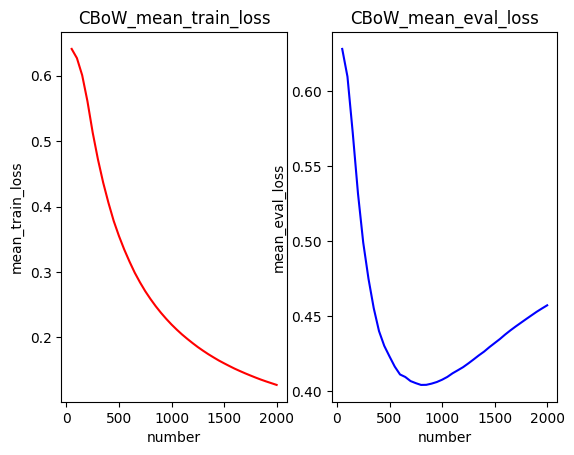

In [ ]:
plt.subplot(1, 2, 1) # row 1, col 2 index 1
sns.lineplot(data=df1, x= df1["number"], y=df1['mean_train_loss'],color = "red")
plt.title("CBoW_mean_train_loss")

plt.subplot(1, 2, 2) # index 2
sns.lineplot(data=df1, x= df1["number"], y=df1['mean_eval_loss'],color = "blue")
plt.title("CBoW_mean_eval_loss")
plt.show()

### 12. Plot your accuracy curves

TODO: You should implement this yourself. Use the `metrics_dict` returned by the training loop.

<ipython-input-17-9e10bc5ad025>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1) # row 1, col 2 index 1


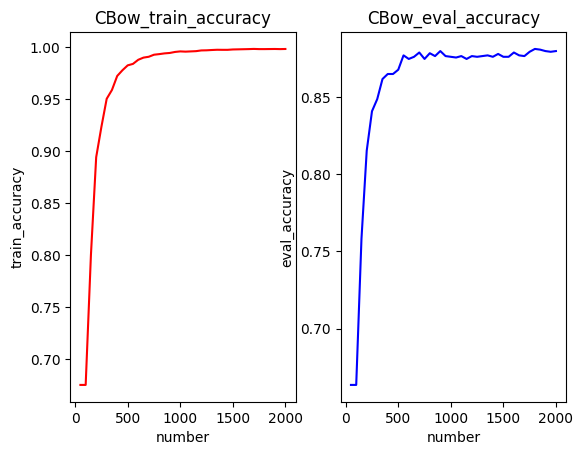

In [ ]:
# TODO
acc_list =[]
metrics_dict
for num in metrics_dict.keys():
#   print(num, metrics_dict[num]['eval_accuracy'],metrics_dict[num]['train_accuracy'])
    acc_list.append((num, metrics_dict[num]['eval_accuracy'],metrics_dict[num]['train_accuracy']))
    
df2 = pd.DataFrame(acc_list, columns =['number','eval_accuracy','train_accuracy'])
sns.lineplot(data=df2[['eval_accuracy', 'train_accuracy']])

plt.subplot(1, 2, 1) # row 1, col 2 index 1
sns.lineplot(data=df2, x= df2["number"], y=df2['train_accuracy'],color = "red")
plt.title("CBow_train_accuracy")

plt.subplot(1, 2, 2) # index 2
sns.lineplot(data=df2, x= df2["number"], y=df2['eval_accuracy'],color = "blue")
plt.title("CBow_eval_accuracy")
plt.show()

### 13. Project the word embeddings for the most common words and label the ones farthest from the mean

TODO: You should implement this yourself. Use the method defined in `CBoWClassifier` above to get the word embeddings of the most common words.

In [ ]:
# TODO

### 14. Repeat training and evaluation procedure with DistilBERT

Here, we set our hyper-parameters for the dataloader (batch size) and the training loop \
(number of epochs, learning rate, and evaluation interval in steps).

We only use basic data loading functionality and the DistilBERT collate function. More information on available features can be found here https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader.

We use `DistilBertForSequenceClassification` and its `DistilBertTokenizerFast` from Hugging Face:
- https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.DistilBertForSequenceClassification
- https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.DistilBertTokenizerFast

In [ ]:
import math
# TODO: set your hyperparameters
bs = 32
num_epochs = 3
lr = 5*math.e**-5
eval_steps = 250

# Train model and save training and evaluation metrics
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_dataset = IDSTextTokenizedDataset(train_texts, train_labels, tokenizer)
validation_dataset = IDSTextTokenizedDataset(validation_texts, validation_labels, tokenizer)
test_dataset = IDSTextTokenizedDataset(test_texts, test_labels, tokenizer)

train_dataloader = DataLoader(
  train_dataset, collate_fn=distilbert_collate_fn, batch_size=bs, shuffle=True
)
validation_dataloader = DataLoader(
  validation_dataset, collate_fn=distilbert_collate_fn, batch_size=bs, shuffle=False
)
test_dataloader = DataLoader(
  test_dataset, collate_fn=distilbert_collate_fn, batch_size=bs, shuffle=False
)

metrics_dict = train(
  model, train_dataloader, validation_dataloader, num_epochs=num_epochs, lr=lr, eval_steps=eval_steps
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Saved new best model to best_model.pt

Starting model training


Evaluating: 100%|██████████| 68/68 [00:04<00:00, 16.76it/s]

Evaluating: 100%|██████████| 539/539 [00:37<00:00, 14.36it/s]



Metrics step 250:
  mean_train_loss: 3.6797019687891006
  learning_rate: 0.02850189601885509
  eval_loss: 0.6370962459374877
  eval_accuracy: 0.6635730862617493
  train_loss: 0.6303860312379579
  train_accuracy: 0.6752508282661438
  mean_eval_loss: 0.6370962459374877


Epoch 1:  46%|████▋     | 250/539 [01:31<1:02:06, 12.89s/it]

Saved new best model to best_model.pt



Evaluating: 100%|██████████| 68/68 [00:04<00:00, 16.34it/s]

Evaluating: 100%|██████████| 539/539 [00:38<00:00, 13.95it/s]



Metrics step 500:
  mean_train_loss: 2.1565080206990244
  learning_rate: 0.023293222347597814
  eval_loss: 0.6370287296526572
  eval_accuracy: 0.6635730862617493
  train_loss: 0.6304221551360801
  train_accuracy: 0.6752508282661438
  mean_eval_loss: 0.6370624877950725


Epoch 1:  93%|█████████▎| 500/539 [03:04<08:37, 13.27s/it]

Saved new best model to best_model.pt



Evaluating: 100%|██████████| 68/68 [00:04<00:00, 16.22it/s]

Epoch 2:  39%|███▉      | 211/539 [01:26<1:12:29, 13.26s/it]


Metrics step 750:
  mean_train_loss: 1.647440518895785
  learning_rate: 0.018084548676340545
  eval_loss: 0.6409938953378621
  eval_accuracy: 0.6635730862617493
  train_loss: 0.6327185900069787
  train_accuracy: 0.6752508282661438
  mean_eval_loss: 0.6383729569760024


Evaluating: 100%|██████████| 68/68 [00:04<00:00, 15.92it/s]

Epoch 2:  86%|████████▌ | 461/539 [03:01<17:21, 13.36s/it]


Metrics step 1000:
  mean_train_loss: 1.3931454976201056
  learning_rate: 0.012875875005083231
  eval_loss: 0.637118865023641
  eval_accuracy: 0.6635730862617493
  train_loss: 0.6310012417401365
  train_accuracy: 0.6752508282661438
  mean_eval_loss: 0.638059433987912


Evaluating: 100%|██████████| 68/68 [00:04<00:00, 15.80it/s]

Epoch 3:  32%|███▏      | 172/539 [01:19<1:22:12, 13.44s/it]


Metrics step 1250:
  mean_train_loss: 1.2398334133148194
  learning_rate: 0.00766720133382589
  eval_loss: 0.6372008139596266
  eval_accuracy: 0.6635730862617493
  train_loss: 0.6303487311710011
  train_accuracy: 0.6752508282661438
  mean_eval_loss: 0.637887709982255


Evaluating: 100%|██████████| 68/68 [00:04<00:00, 15.81it/s]

Epoch 3:  78%|███████▊  | 422/539 [02:55<26:08, 13.41s/it]


Metrics step 1500:
  mean_train_loss: 1.1390261254906655
  learning_rate: 0.002458527662568492
  eval_loss: 0.6371408994583523
  eval_accuracy: 0.6635730862617493
  train_loss: 0.6304040776776472
  train_accuracy: 0.6752508282661438
  mean_eval_loss: 0.6377632415616045


Epoch 3: 100%|██████████| 539/539 [03:19<00:00,  2.70it/s]


### 15. Evaluate your best model on the test split

TODO: You should implement this yourself as above.

In [ ]:
# TODO
# TODO
best_model = load_best_model(model)
e = evaluate(best_model,test_dataloader)

Loaded best DistilBertForSequenceClassification model from best_model.pt



Evaluating: 100%|██████████| 68/68 [00:04<00:00, 15.94it/s]


In [ ]:
e

{'eval_loss': 0.6362379447502249,
 'eval_accuracy': 0.6691415309906006,
 'eval_conf_matrix': array([[   0,  713],
        [   0, 1442]])}

### 16. Visualize your loss curves

TODO: You should implement this yourself as above.

In [ ]:
# TODO
# TODO
loss_list =[]
metrics_dict
for num in metrics_dict.keys():
#   print(num, metrics_dict[num]['mean_train_loss'],metrics_dict[num]['mean_eval_loss'])
   loss_list.append((num, metrics_dict[num]['mean_train_loss'],metrics_dict[num]['mean_eval_loss']))
df_Bert = pd.DataFrame(loss_list, columns =['number','Bert_mean_train_loss','Bert_mean_eval_loss'])
#sns.lineplot(data=df1, x= df1["number"], y=df1['mean_train_loss'],color = "red")
#sns.lineplot(data=df1, x= df1["number"], y=df1['mean_eval_loss'],color = "blue")


In [ ]:
df_join = pd.merge(df1,df_Bert, how='inner', on ='number')
df_join

,number,mean_train_loss,mean_eval_loss,Bert_mean_train_loss,Bert_mean_eval_loss
0,250,0.513149,0.498978,3.679702,0.637096
1,500,0.355035,0.423002,2.156508,0.637062
2,750,0.270732,0.405163,1.647441,0.638373
3,1000,0.219816,0.407441,1.393145,0.638059
4,1250,0.185381,0.418342,1.239833,0.637888
5,1500,0.160549,0.431902,1.139026,0.637763


Text(0.5, 1.0, 'Mean train loss compariosn Cbow vs DistilBERT')

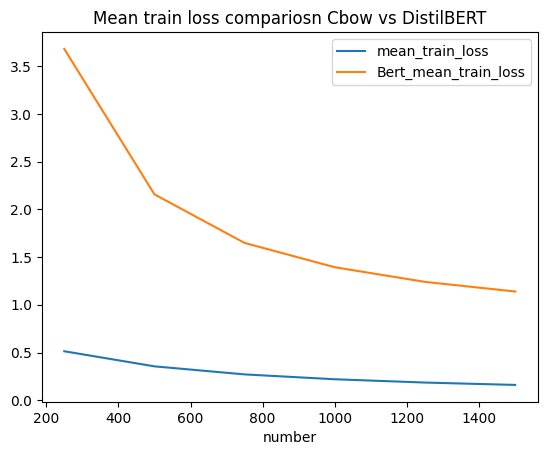

In [ ]:
df_join.plot(x='number',y=['mean_train_loss','Bert_mean_train_loss'])
plt.title('Mean train loss compariosn Cbow vs DistilBERT')

Text(0.5, 1.0, 'Mean eval loss compariosn Cbow vs DistilBERT')

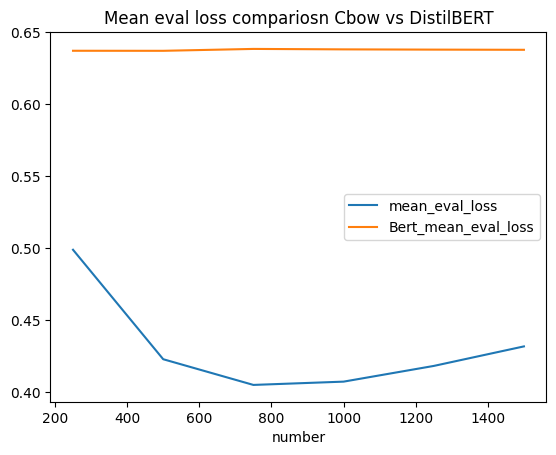

In [ ]:
df_join.plot(x='number',y=['mean_eval_loss','Bert_mean_eval_loss'])
plt.title('Mean eval loss compariosn Cbow vs DistilBERT')

### 16. Visualize your accuracy curves

TODO: You should implement this yourself as above.

In [ ]:
# TODO

# TODO
acc_list =[]
metrics_dict
for num in metrics_dict.keys():
#   print(num, metrics_dict[num]['eval_accuracy'],metrics_dict[num]['train_accuracy'])
    acc_list.append((num, metrics_dict[num]['eval_accuracy'],metrics_dict[num]['train_accuracy']))
    
df2_Bert = pd.DataFrame(acc_list, columns =['number','Bert_eval_accuracy','Bert_train_accuracy'])

df_acc = pd.merge(df2,df2_Bert, how='inner', on ='number')
df_acc

,number,eval_accuracy,train_accuracy,Bert_eval_accuracy,Bert_train_accuracy
0,250,0.840835,0.923380,0.663573,0.675251
1,500,0.867749,0.982310,0.663573,0.675251
2,750,0.874710,0.992518,0.663573,0.675251
3,1000,0.876102,0.995708,0.663573,0.675251
4,1250,0.876102,0.996752,0.663573,0.675251
5,1500,0.876102,0.997564,0.663573,0.675251


In [ ]:
metrics_dict

{250: {'mean_train_loss': 3.6797019687891006,
  'learning_rate': 0.02850189601885509,
  'eval_loss': 0.6370962459374877,
  'eval_accuracy': 0.6635730862617493,
  'eval_conf_matrix': array([[   0,  725],
         [   0, 1430]]),
  'train_loss': 0.6303860312379579,
  'train_accuracy': 0.6752508282661438,
  'train_conf_matrix': array([[    0,  5599],
         [    0, 11642]]),
  'mean_eval_loss': 0.6370962459374877},
 500: {'mean_train_loss': 2.1565080206990244,
  'learning_rate': 0.023293222347597814,
  'eval_loss': 0.6370287296526572,
  'eval_accuracy': 0.6635730862617493,
  'eval_conf_matrix': array([[   0,  725],
         [   0, 1430]]),
  'train_loss': 0.6304221551360801,
  'train_accuracy': 0.6752508282661438,
  'train_conf_matrix': array([[    0,  5599],
         [    0, 11642]]),
  'mean_eval_loss': 0.6370624877950725},
 750: {'mean_train_loss': 1.647440518895785,
  'learning_rate': 0.018084548676340545,
  'eval_loss': 0.6409938953378621,
  'eval_accuracy': 0.6635730862617493,
  '

Text(0.5, 1.0, 'Train accuracy compariosn Cbow vs DistilBERT')

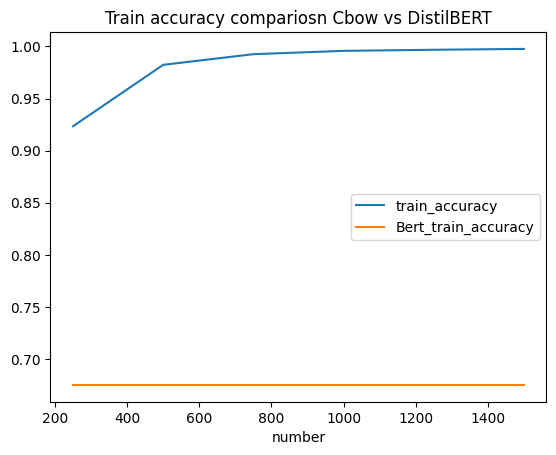

In [ ]:
df_acc.plot(x='number',y=['train_accuracy','Bert_train_accuracy'])
plt.title('Train accuracy compariosn Cbow vs DistilBERT')

Text(0.5, 1.0, 'Eval accuracy compariosn Cbow vs DistilBERT')

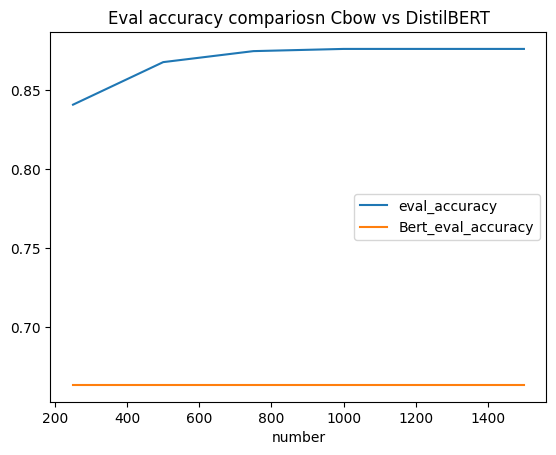

In [ ]:
df_acc.plot(x='number',y=['eval_accuracy','Bert_eval_accuracy'])
plt.title('Eval accuracy compariosn Cbow vs DistilBERT')